# Introduction

From Ddareungi’s perspective, it is important to make the rental bike available and accessible to the
public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of
rental bikes becomes the main objective. Thus, a crucial task is to accurately estimate the bike count
required at each hour for the stable supply of rental bikes.

# 3.1 Data Understanding

In [1]:
#Import libraries

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

# use Matplotlib for additional customization
import matplotlib.pyplot as plt
#sets the backend of matplotlib to the 'inline' backend
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

# Seaborn for plotting and styling
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
#import data
bikes = pd.read_csv('SeoulBike.csv', low_memory=False)
bikes.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
bikes['Date']

0        1/12/2017
1        1/12/2017
2        1/12/2017
3        1/12/2017
4        1/12/2017
           ...    
8755    30/11/2018
8756    30/11/2018
8757    30/11/2018
8758    30/11/2018
8759    30/11/2018
Name: Date, Length: 8760, dtype: object

**Binning dates**

In [4]:
# Convert the 'Date' column to datetime
bikes['Date'] = pd.to_datetime(bikes['Date'], format='%d/%m/%Y')

# Bin the dates into quarters
quarters = pd.cut(bikes['Date'], bins=pd.date_range(start='01/01/2017', end='30/11/2018', freq='Q'))
bikes['quarter'] = quarters

**Check rows, columns and data types**

In [5]:
bikes.dtypes

Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
quarter                            category
dtype: object

In [6]:
bikes.shape

(8760, 15)

In [7]:
bikes.describe()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2018-05-31 23:59:59.999999744,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
min,2017-12-01 00:00:00,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,2018-03-02 00:00:00,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,2018-06-01 00:00:00,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,2018-08-31 00:00:00,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,2018-11-30 00:00:00,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746


# 3.2 Data Preparation

**Data preparation (cleaning, transformation, handling duplicates, handling missing values, encoding categorical features, etc.)**

In [8]:
bikes.isnull().sum()

Date                            0
Rented Bike Count               0
Hour                            0
Temperature(°C)                 0
Humidity(%)                     0
Wind speed (m/s)                0
Visibility (10m)                0
Dew point temperature(°C)       0
Solar Radiation (MJ/m2)         0
Rainfall(mm)                    0
Snowfall (cm)                   0
Seasons                         0
Holiday                         0
Functioning Day                 0
quarter                      1464
dtype: int64

**Updating Hour Column - 0 to 6 hours: Morning, 7 to 12 hours: Afternoon, 13-18 hrs: Evening, 19-23: Night**

In [9]:
# Define a function to categorize hours
def categorize_time(hour):
    if 0 <= hour <= 6:
        return "Morning"
    elif 7 <= hour <= 12:
        return "Afternoon"
    elif 13 <= hour <= 18:
        return "Evening"
    elif 19 <= hour <= 23:
        return "Night"
    else:
        return "Invalid"

bikes['Hour_updated'] = bikes['Hour'].apply(categorize_time)

In [10]:
# Filtered Data Bikes

df = bikes.drop(['Hour'], axis = 1)

In [11]:
df.head()

,Date,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,quarter,Hour_updated
0,2017-12-01,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,"(2017-09-30, 2017-12-31]",Morning
1,2017-12-01,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,"(2017-09-30, 2017-12-31]",Morning
2,2017-12-01,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,"(2017-09-30, 2017-12-31]",Morning
3,2017-12-01,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,"(2017-09-30, 2017-12-31]",Morning
4,2017-12-01,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,"(2017-09-30, 2017-12-31]",Morning


**Mapping holiday & no holiday to 0 and 1**

In [12]:
mapping = {'No Holiday': True, 'Holiday': False}
#Use the replace method to convert to binary
df['Holiday_updated'] = df['Holiday'].replace(mapping)
df.head()

,Date,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,quarter,Hour_updated,Holiday_updated
0,2017-12-01,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,"(2017-09-30, 2017-12-31]",Morning,True
1,2017-12-01,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,"(2017-09-30, 2017-12-31]",Morning,True
2,2017-12-01,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,"(2017-09-30, 2017-12-31]",Morning,True
3,2017-12-01,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,"(2017-09-30, 2017-12-31]",Morning,True
4,2017-12-01,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,"(2017-09-30, 2017-12-31]",Morning,True


In [13]:
#Dropping holiday column

df.drop(['Holiday'], axis=1, inplace=True)

In [14]:
df['Seasons'].unique()

array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

**One hot encoding for Seasons**

In [15]:
df2 = pd.get_dummies(df['Seasons'])

In [16]:
df2

,Autumn,Spring,Summer,Winter
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,False,False,False,True
...,...,...,...,...
8755,True,False,False,False
8756,True,False,False,False
8757,True,False,False,False
8758,True,False,False,False


In [17]:
dff = pd.concat([df,df2], axis =1)

In [18]:
dff.drop(['Seasons'], axis=1, inplace=True)

In [19]:
dff

,Date,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,quarter,Hour_updated,Holiday_updated,Autumn,Spring,Summer,Winter
0,2017-12-01,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes,"(2017-09-30, 2017-12-31]",Morning,True,False,False,False,True
1,2017-12-01,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes,"(2017-09-30, 2017-12-31]",Morning,True,False,False,False,True
2,2017-12-01,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes,"(2017-09-30, 2017-12-31]",Morning,True,False,False,False,True
3,2017-12-01,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes,"(2017-09-30, 2017-12-31]",Morning,True,False,False,False,True
4,2017-12-01,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes,"(2017-09-30, 2017-12-31]",Morning,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Yes,NaN,Night,True,True,False,False,False
8756,2018-11-30,764,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Yes,NaN,Night,True,True,False,False,False
8757,2018-11-30,694,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Yes,NaN,Night,True,True,False,False,False
8758,2018-11-30,712,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Yes,NaN,Night,True,True,False,False,False


**One hot encoding for Hour_updated**

In [20]:
df3 = pd.get_dummies(df['Hour_updated'])

In [21]:
df3

,Afternoon,Evening,Morning,Night
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
8755,False,False,False,True
8756,False,False,False,True
8757,False,False,False,True
8758,False,False,False,True


In [22]:
df_updated = pd.concat([dff,df3], axis =1)

In [23]:
df_updated.dtypes

Date                         datetime64[ns]
Rented Bike Count                     int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Functioning Day                      object
quarter                            category
Hour_updated                         object
Holiday_updated                        bool
Autumn                                 bool
Spring                                 bool
Summer                                 bool
Winter                                 bool
Afternoon                              bool
Evening                                bool
Morning                                bool
Night                                  bool
dtype: object

In [24]:
#dropping Hour_updated
df_updated.drop(['Hour_updated'], axis=1, inplace=True)
df_updated

,Date,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),...,quarter,Holiday_updated,Autumn,Spring,Summer,Winter,Afternoon,Evening,Morning,Night
0,2017-12-01,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,...,"(2017-09-30, 2017-12-31]",True,False,False,False,True,False,False,True,False
1,2017-12-01,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,...,"(2017-09-30, 2017-12-31]",True,False,False,False,True,False,False,True,False
2,2017-12-01,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,...,"(2017-09-30, 2017-12-31]",True,False,False,False,True,False,False,True,False
3,2017-12-01,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,...,"(2017-09-30, 2017-12-31]",True,False,False,False,True,False,False,True,False
4,2017-12-01,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,...,"(2017-09-30, 2017-12-31]",True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,...,NaN,True,True,False,False,False,False,False,False,True
8756,2018-11-30,764,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,...,NaN,True,True,False,False,False,False,False,False,True
8757,2018-11-30,694,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,...,NaN,True,True,False,False,False,False,False,False,True
8758,2018-11-30,712,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,...,NaN,True,True,False,False,False,False,False,False,True


**Mapping for Functioning Day**

In [25]:
mapping = {'Yes': True, 'No': False}
#Use the replace method to convert to binary
df_updated['func_updated'] = df_updated['Functioning Day'].replace(mapping)
#Dropping Functioning Day
df_updated.drop(['Functioning Day'], axis = 1, inplace = True)

In [26]:
df_updated.dtypes

Date                         datetime64[ns]
Rented Bike Count                     int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
quarter                            category
Holiday_updated                        bool
Autumn                                 bool
Spring                                 bool
Summer                                 bool
Winter                                 bool
Afternoon                              bool
Evening                                bool
Morning                                bool
Night                                  bool
func_updated                           bool
dtype: object

# 3.3 Data Visualization

**3.3.1 Distribution graphs for numerical columns**

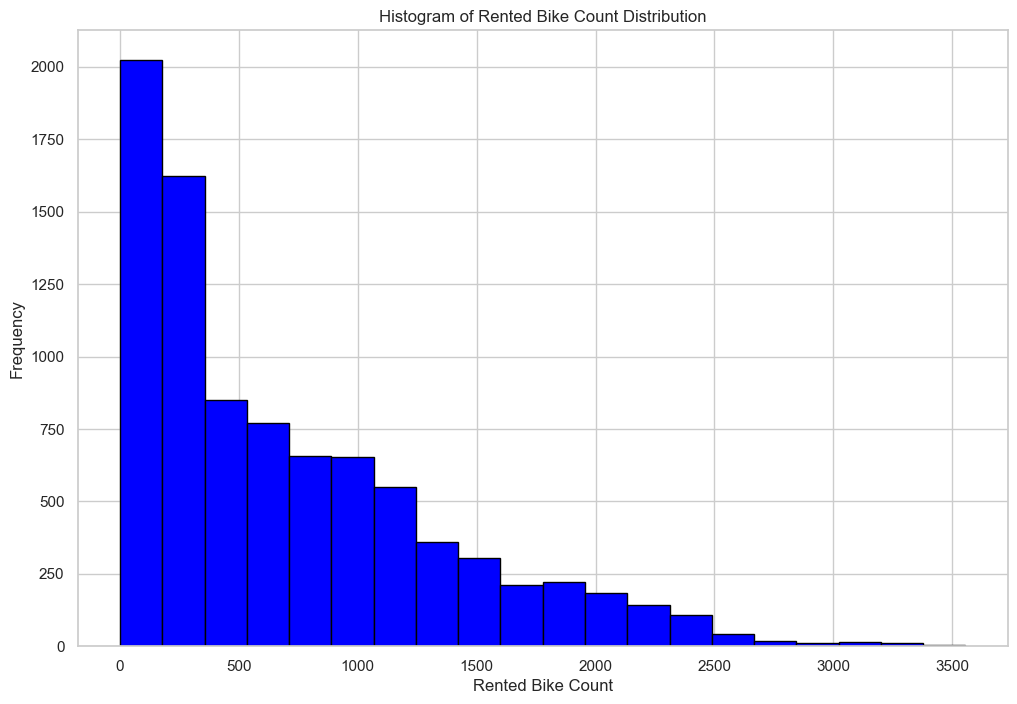

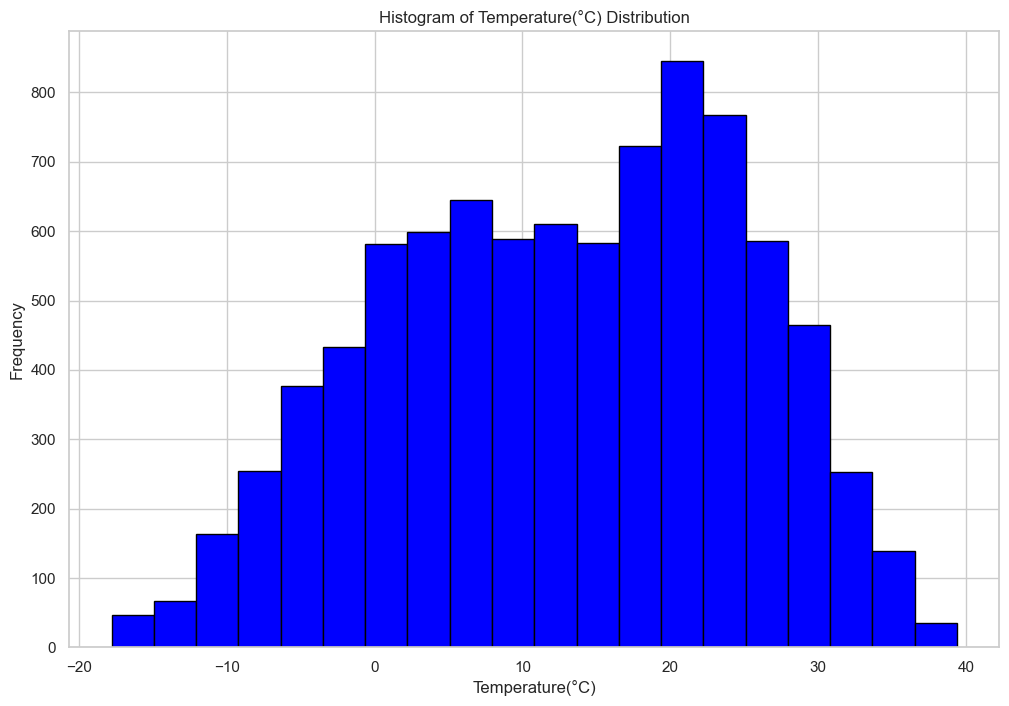

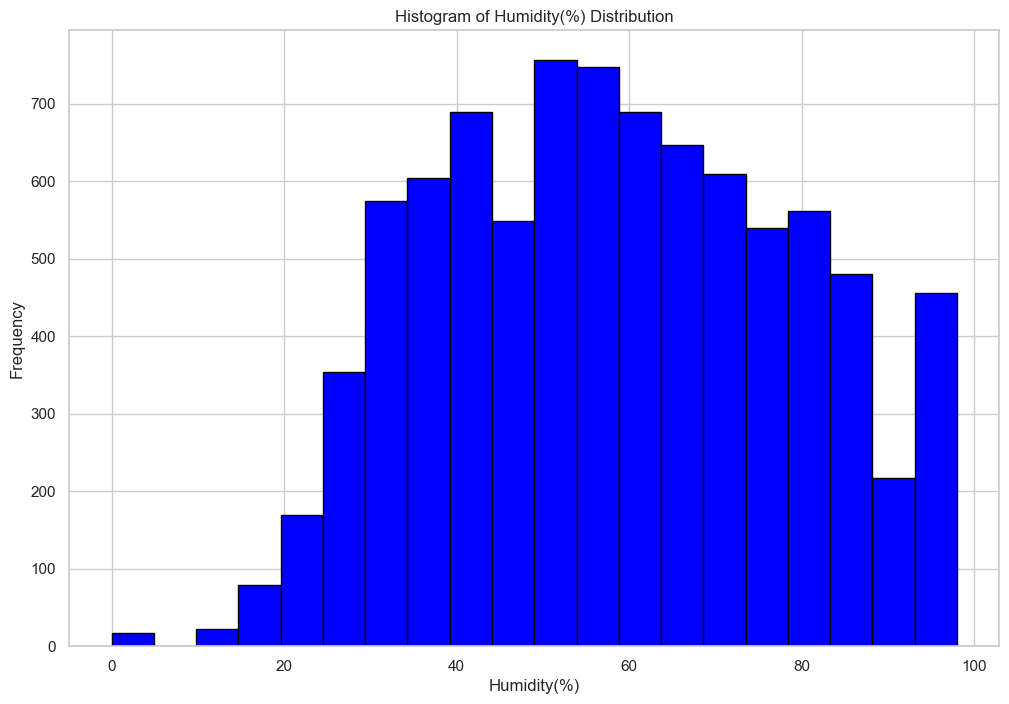

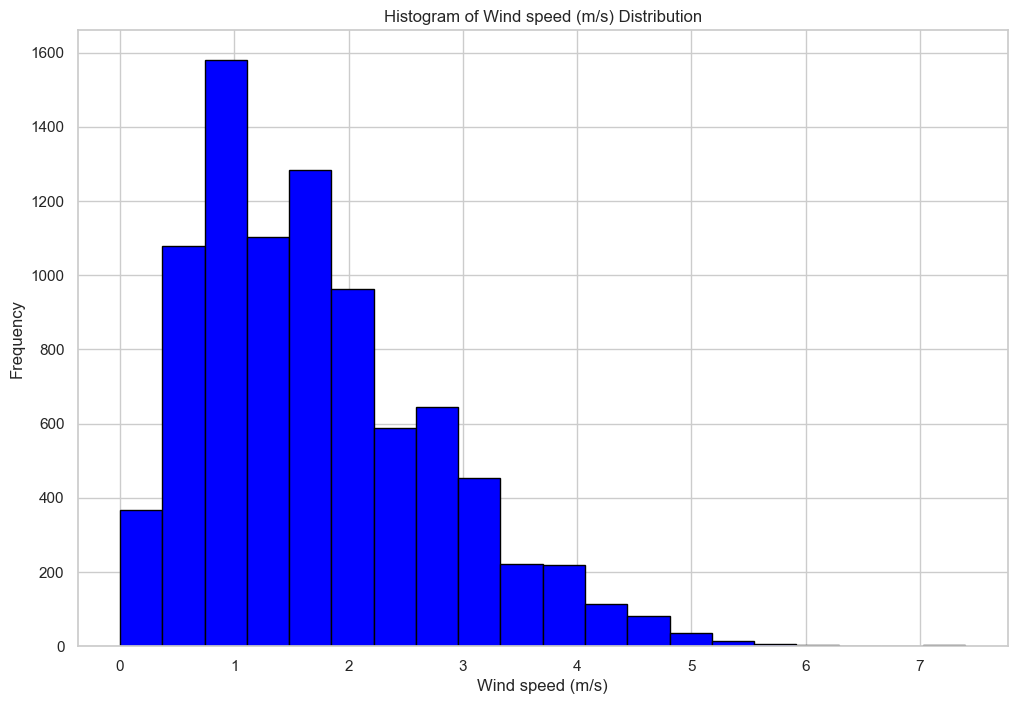

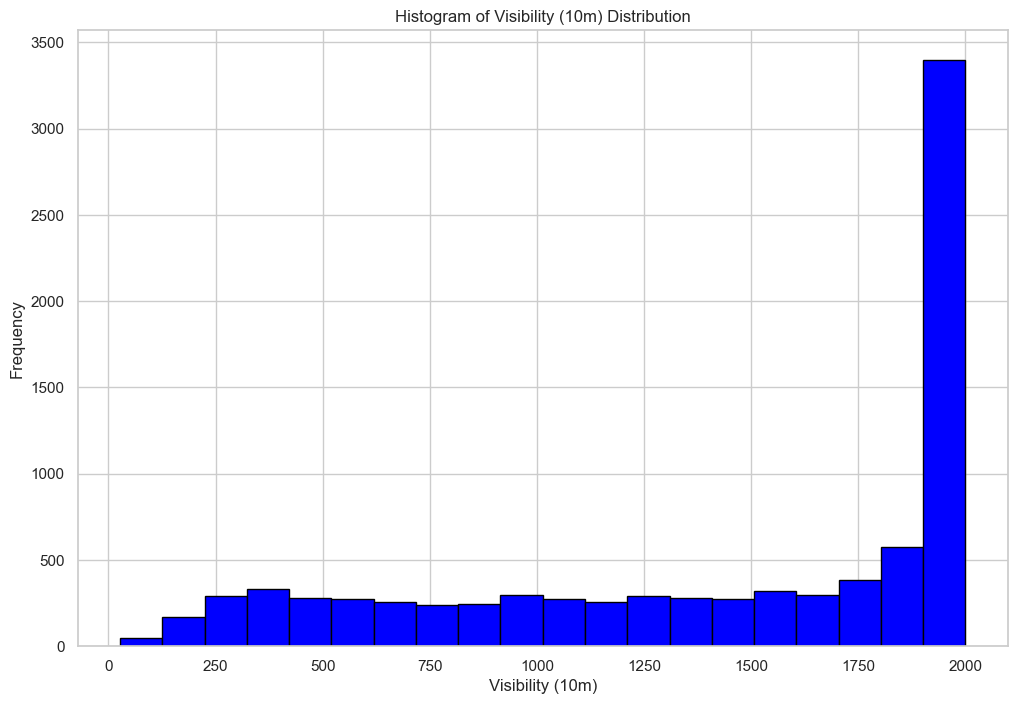

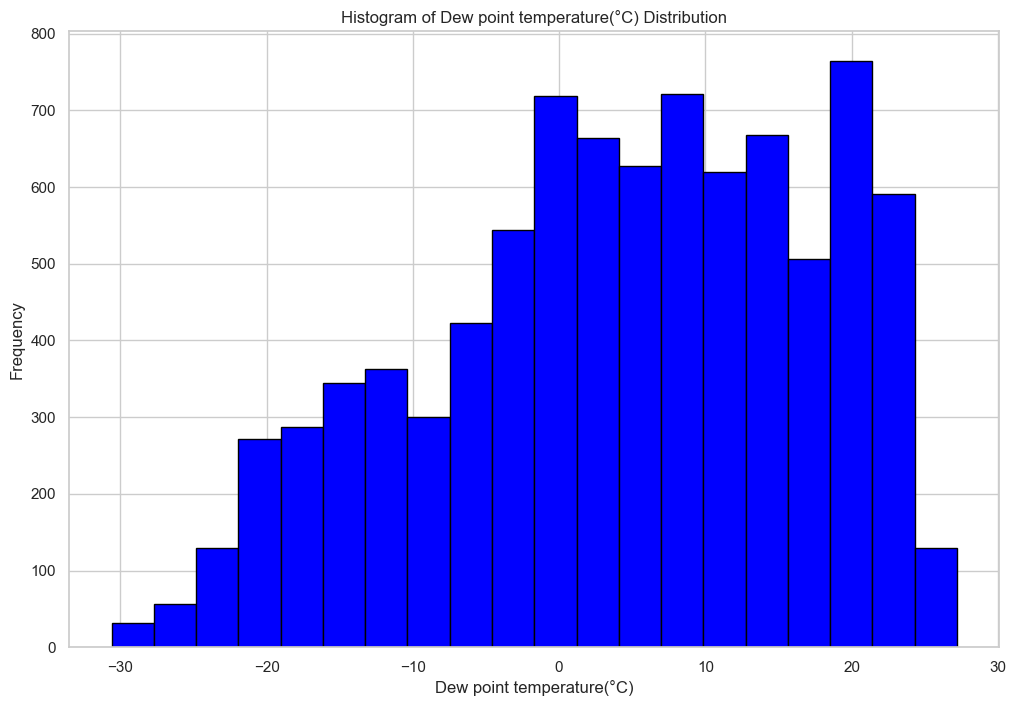

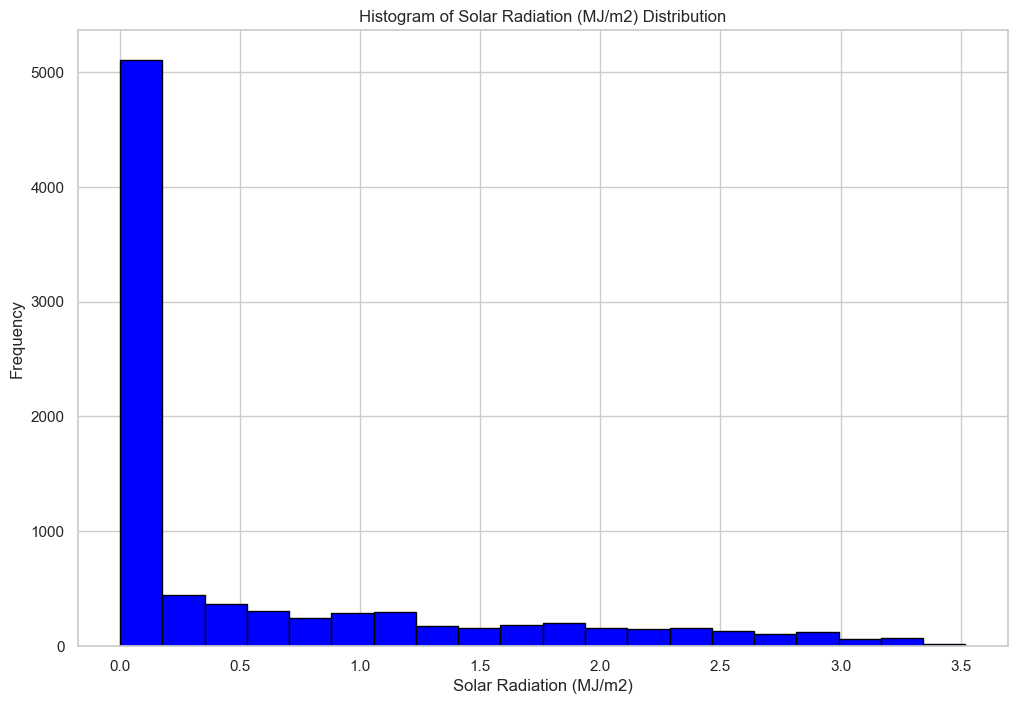

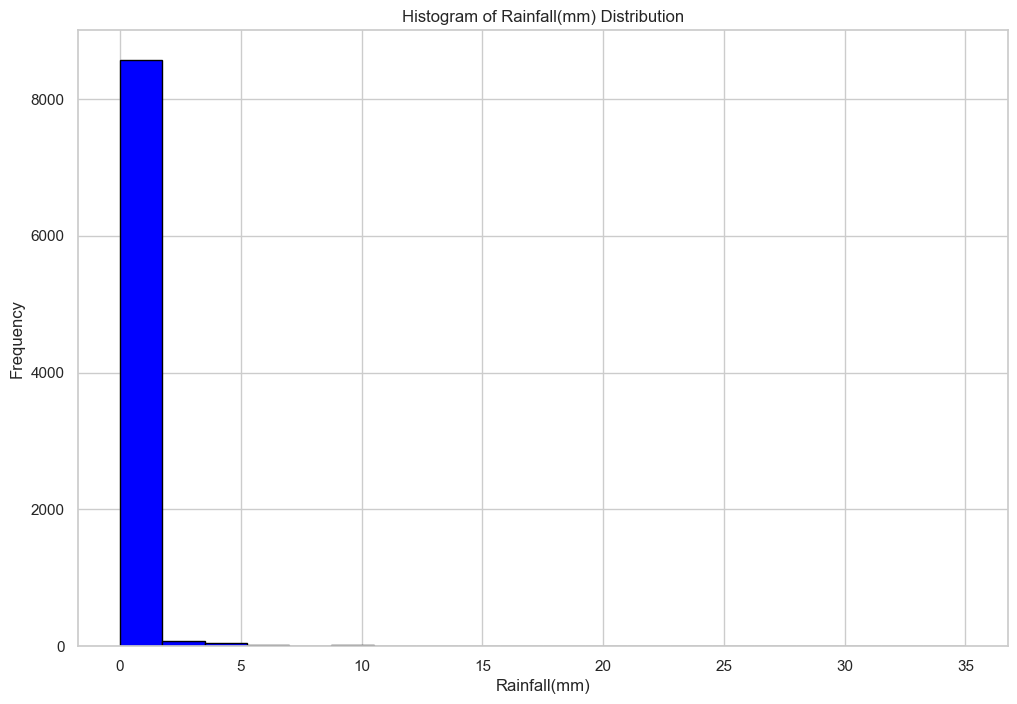

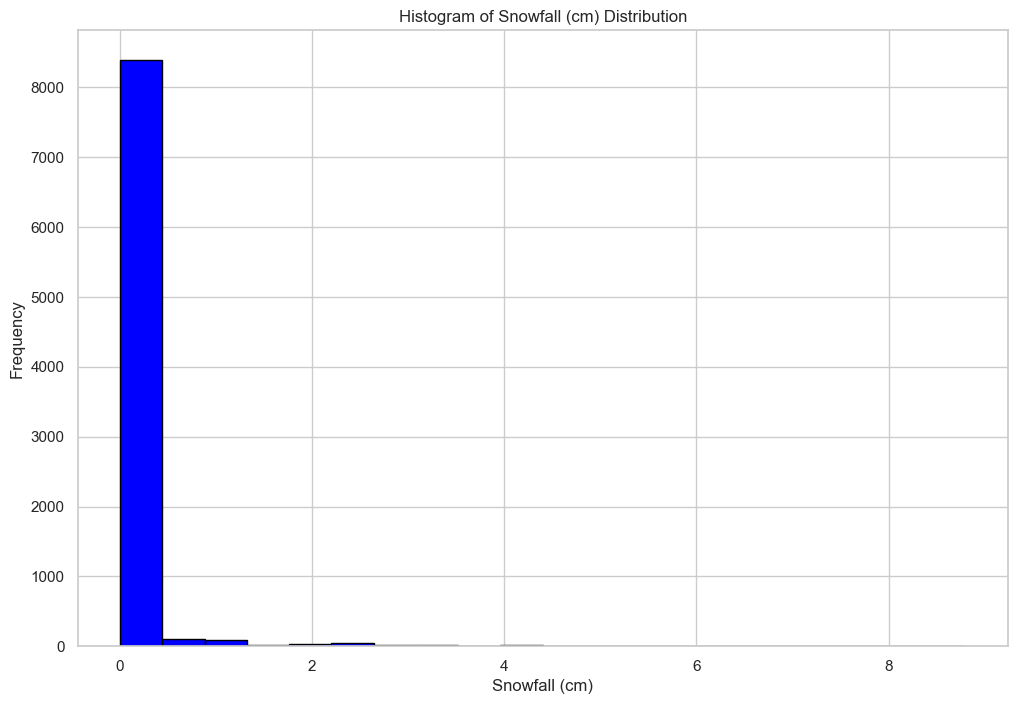

In [27]:
# Distribution graph for int/float columns

columns_to_plot = ['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
for column in columns_to_plot:
    plt.hist(df_updated[column], bins=20, color='blue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column} Distribution')
    plt.rcParams['figure.figsize'] = (12,8)
    plt.show()

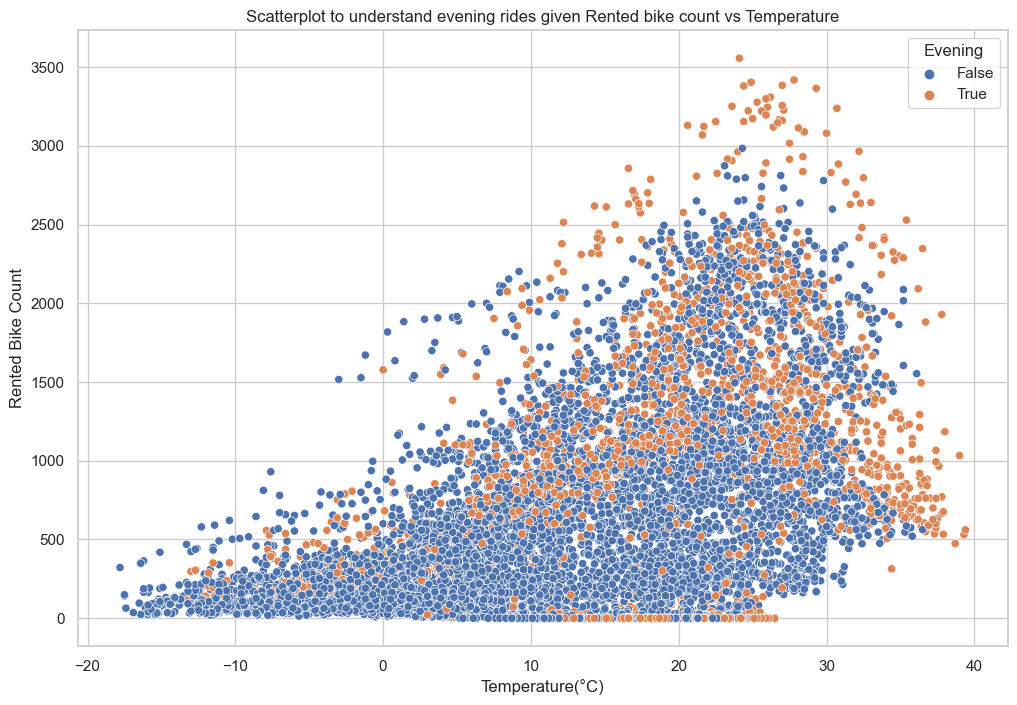

In [28]:
# Use color cue to indicate evening
sns.scatterplot(data = df_updated, x="Temperature(°C)", y="Rented Bike Count", hue='Evening')
plt.title("Scatterplot to understand evening rides given Rented bike count vs Temperature")
plt.show()

**Insight from above plot - For lower temperatures, evening rides are not popular. For higher temperatures, evening rides are popular.**

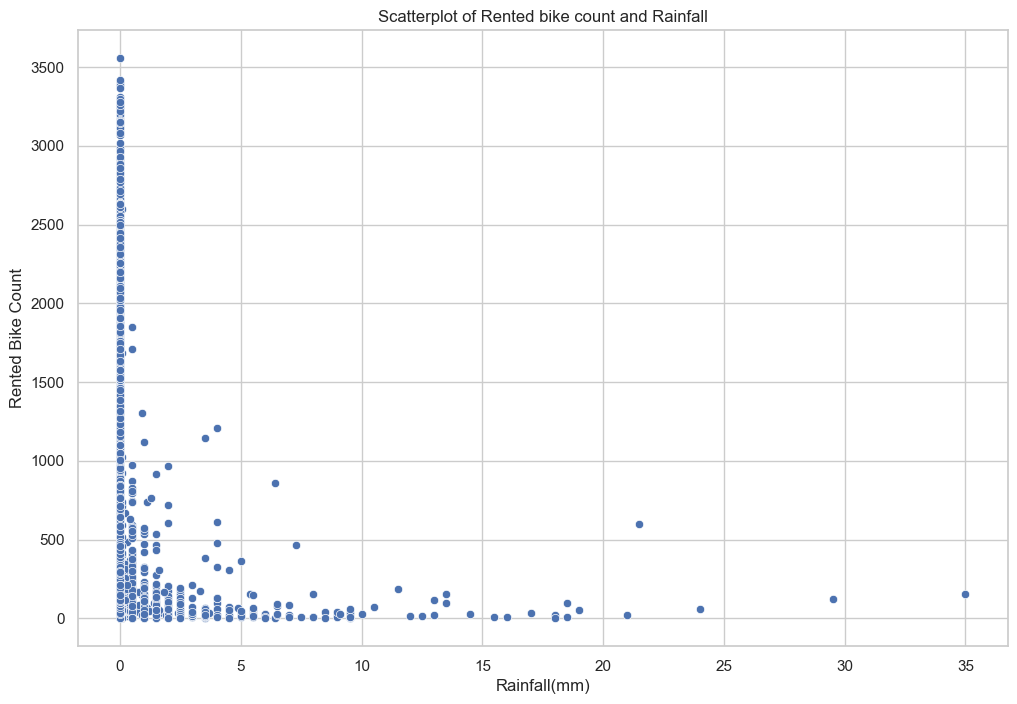

In [29]:
#Plotting Rented bike count against rainfall
sns.scatterplot(data = df_updated, x="Rainfall(mm)", y="Rented Bike Count").set_title("Scatterplot of Rented bike count and Rainfall")
plt.show()

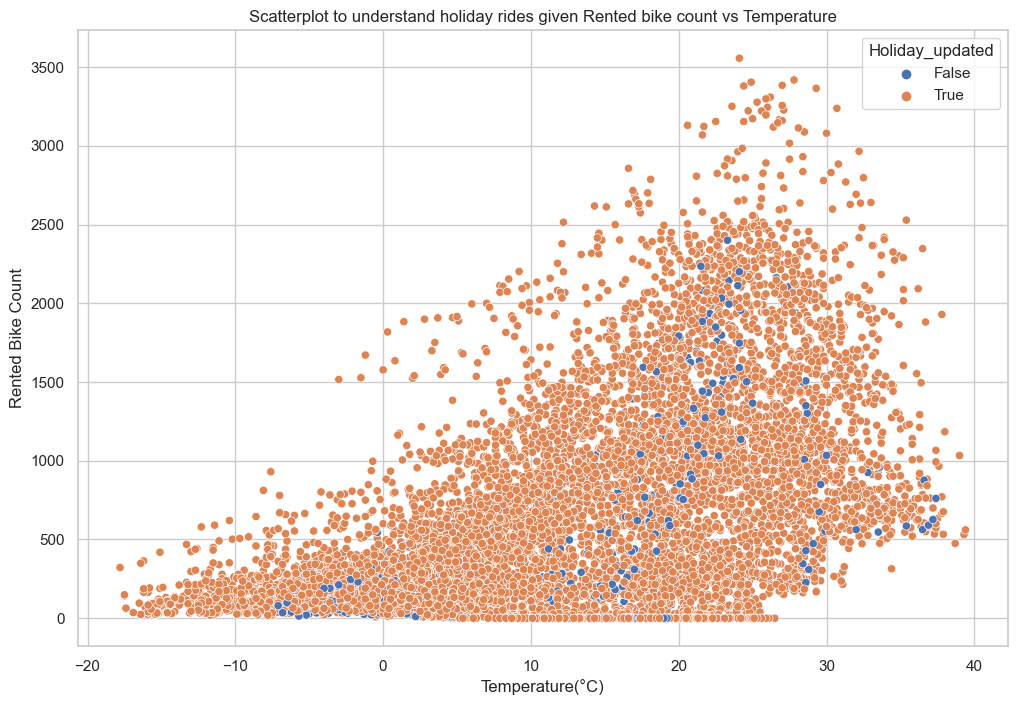

In [30]:
# Use color cue to indicate holiday
sns.scatterplot(data = df_updated, x="Temperature(°C)", y="Rented Bike Count", hue='Holiday_updated')
plt.title("Scatterplot to understand holiday rides given Rented bike count vs Temperature")
plt.show()

**Insight from above plot - Irrespective of temperature, on holidays, people take more rides**

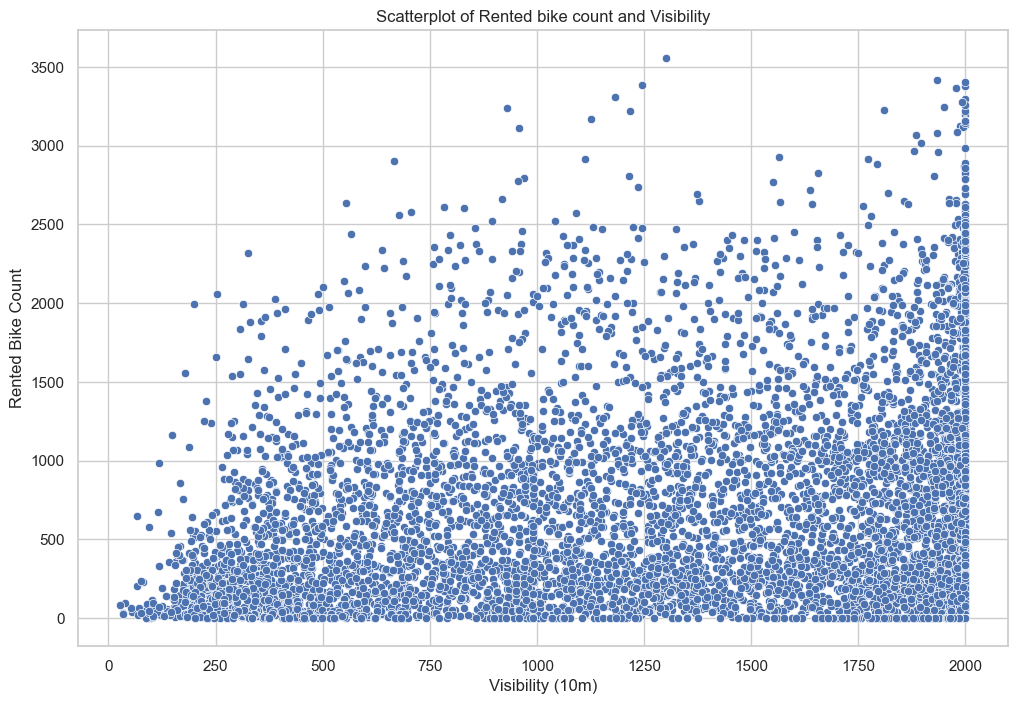

In [31]:
#Plotting Rented bike count against visibility
sns.scatterplot(data = df_updated, x="Visibility (10m)", y="Rented Bike Count").set_title("Scatterplot of Rented bike count and Visibility")
plt.show()

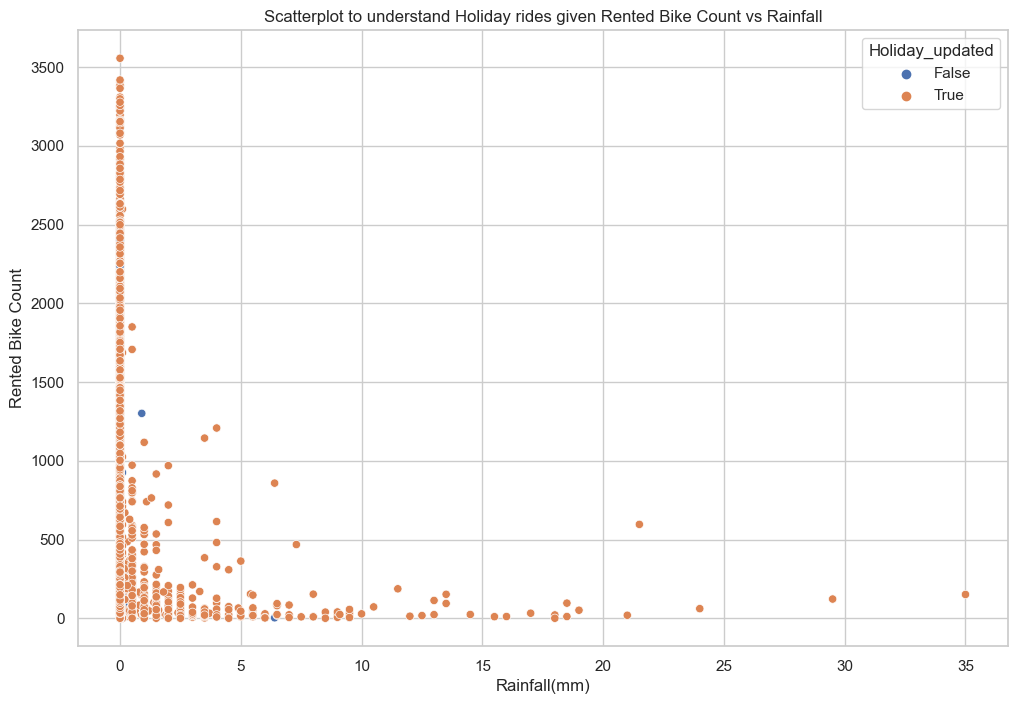

In [32]:
# Use color cue to indicate holiday
sns.scatterplot(data = df_updated, x="Rainfall(mm)", y="Rented Bike Count", hue='Holiday_updated')
plt.title("Scatterplot to understand Holiday rides given Rented Bike Count vs Rainfall")
plt.show()

**Insight from above plot - Within 10 mm rainfall, majority of the rides happen**

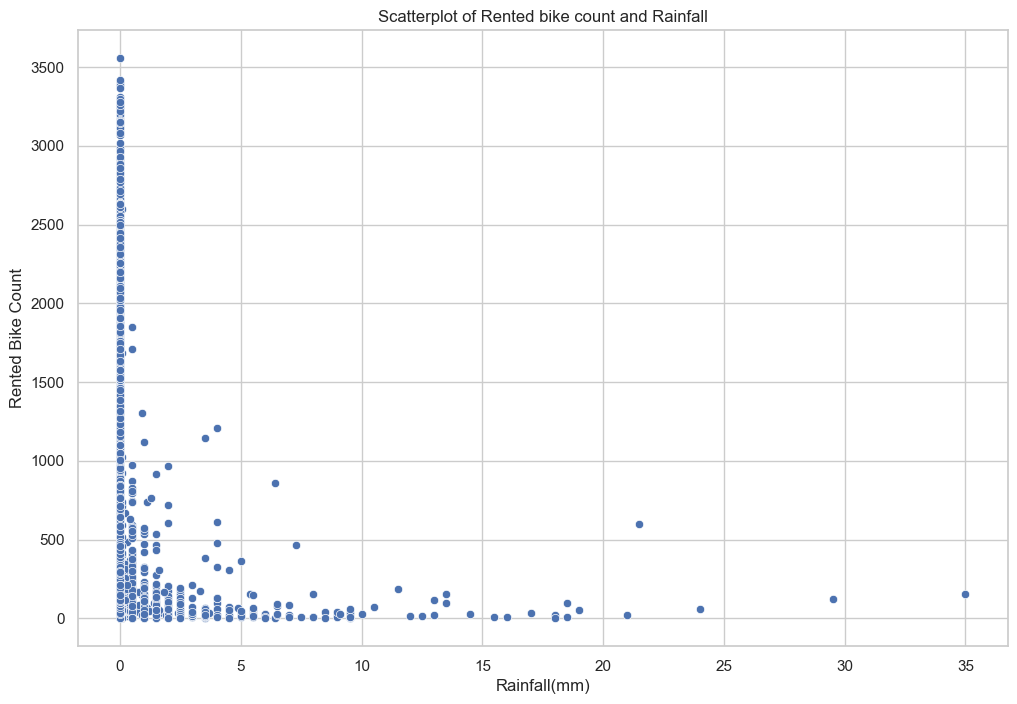

In [33]:
#Plotting Rented bike count against rainfall
sns.scatterplot(data = df_updated, x="Rainfall(mm)", y="Rented Bike Count").set_title("Scatterplot of Rented bike count and Rainfall")
plt.show()

**3.3.2 Bar plot for categorical columns**

In [34]:
df_updated.dtypes

Date                         datetime64[ns]
Rented Bike Count                     int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
quarter                            category
Holiday_updated                        bool
Autumn                                 bool
Spring                                 bool
Summer                                 bool
Winter                                 bool
Afternoon                              bool
Evening                                bool
Morning                                bool
Night                                  bool
func_updated                           bool
dtype: object

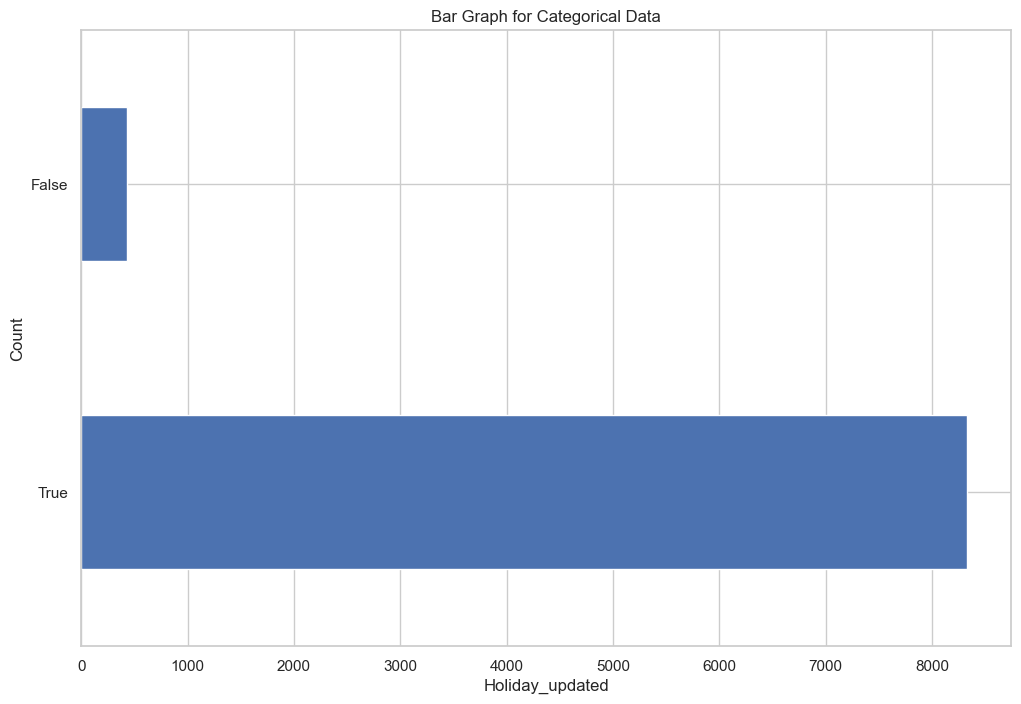

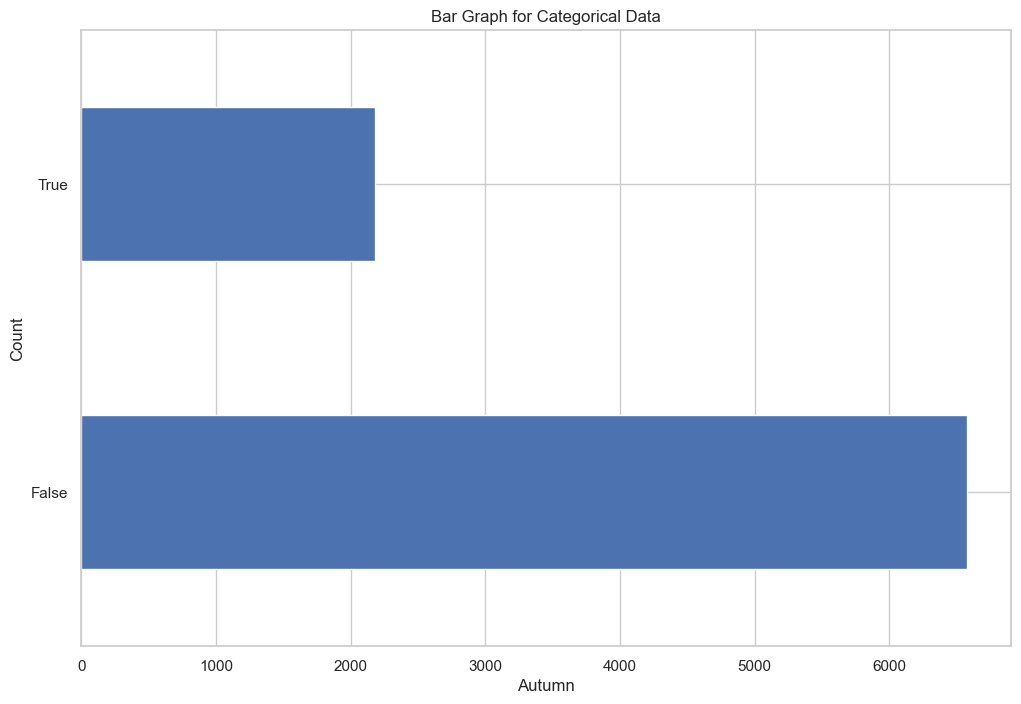

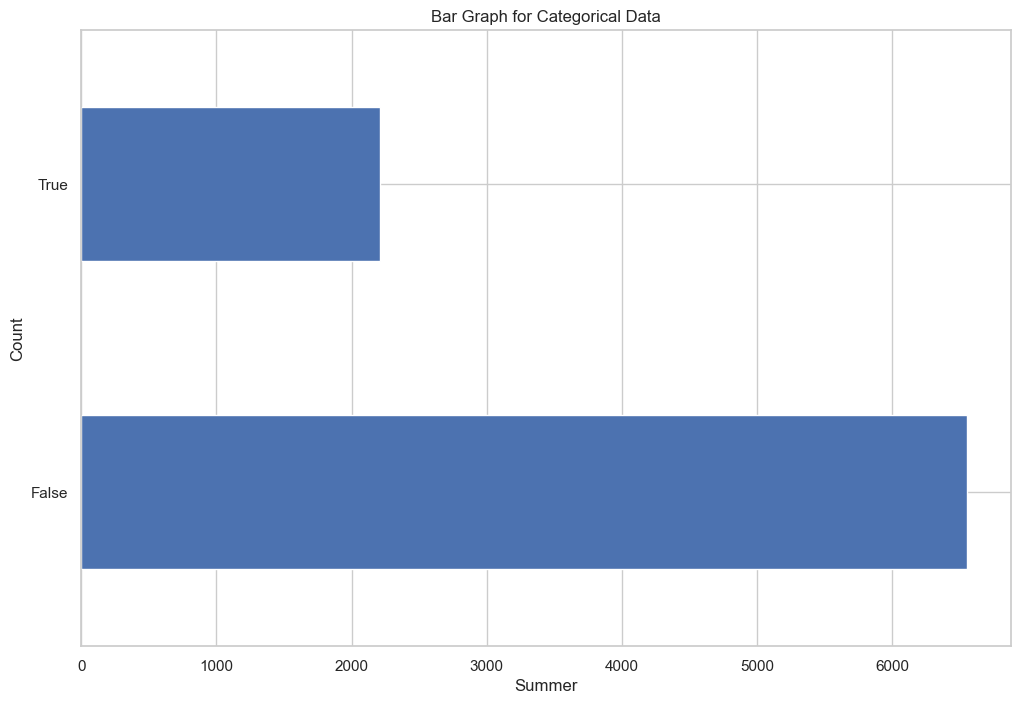

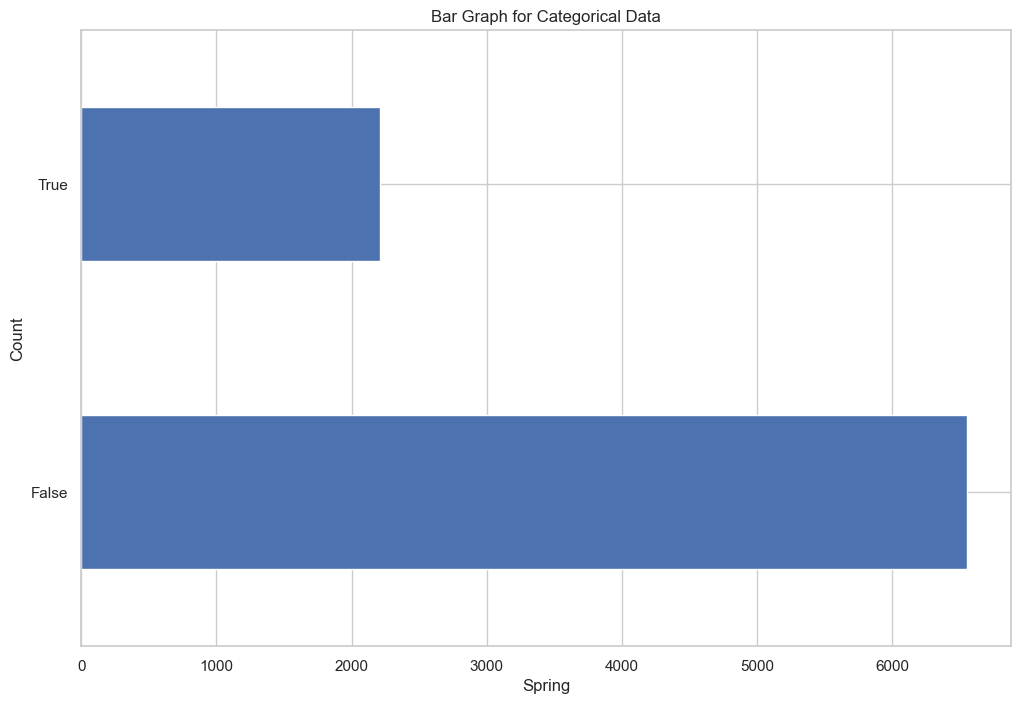

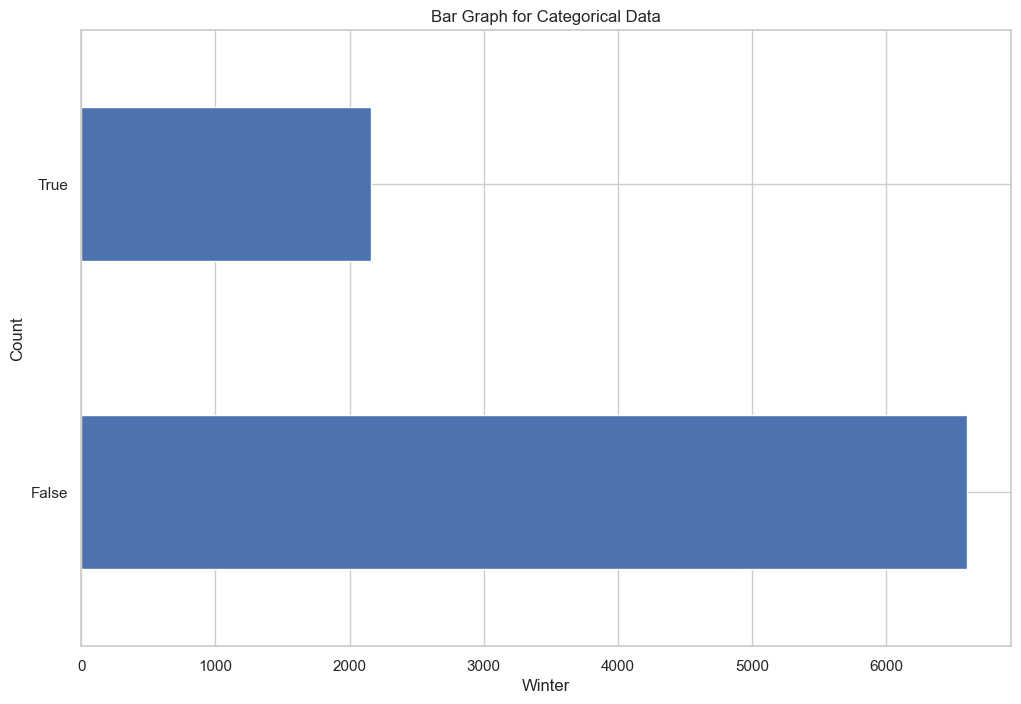

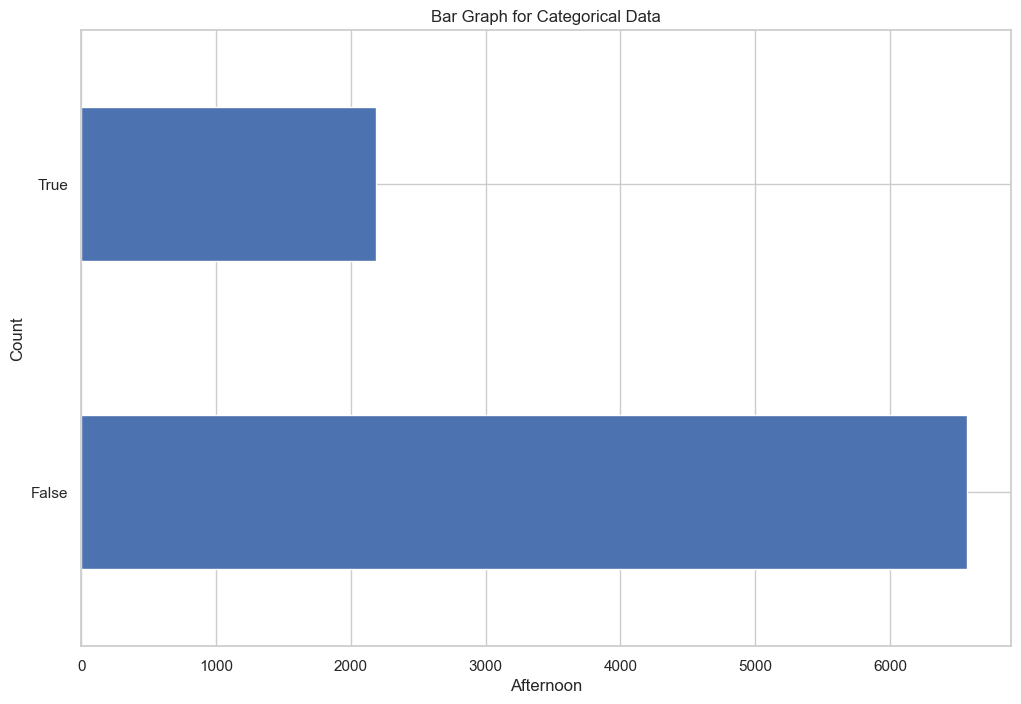

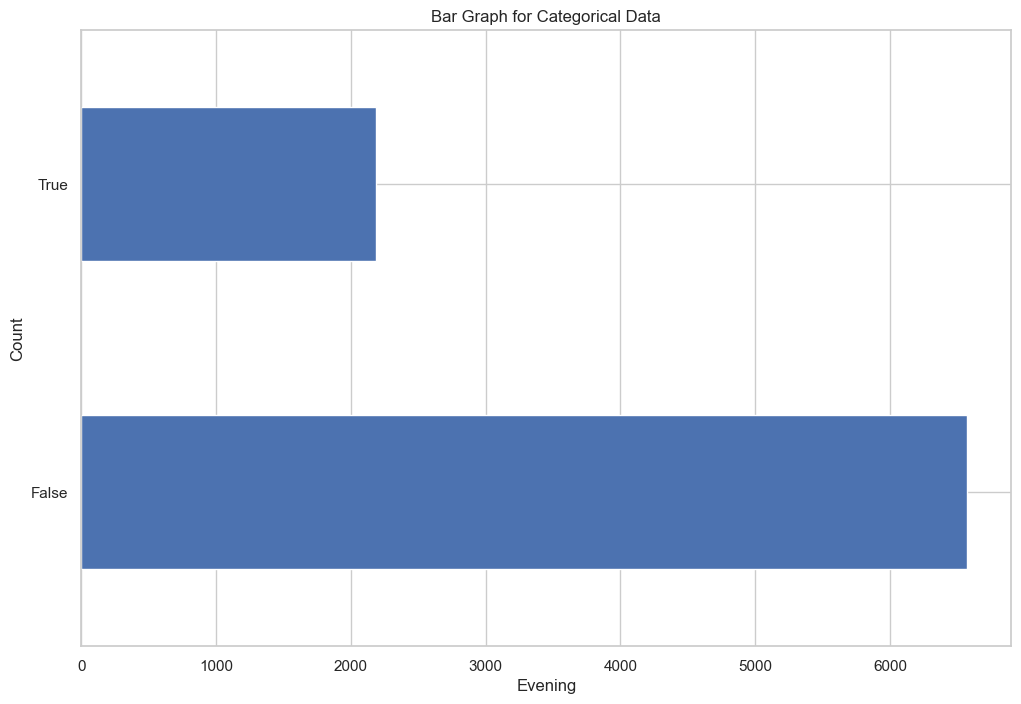

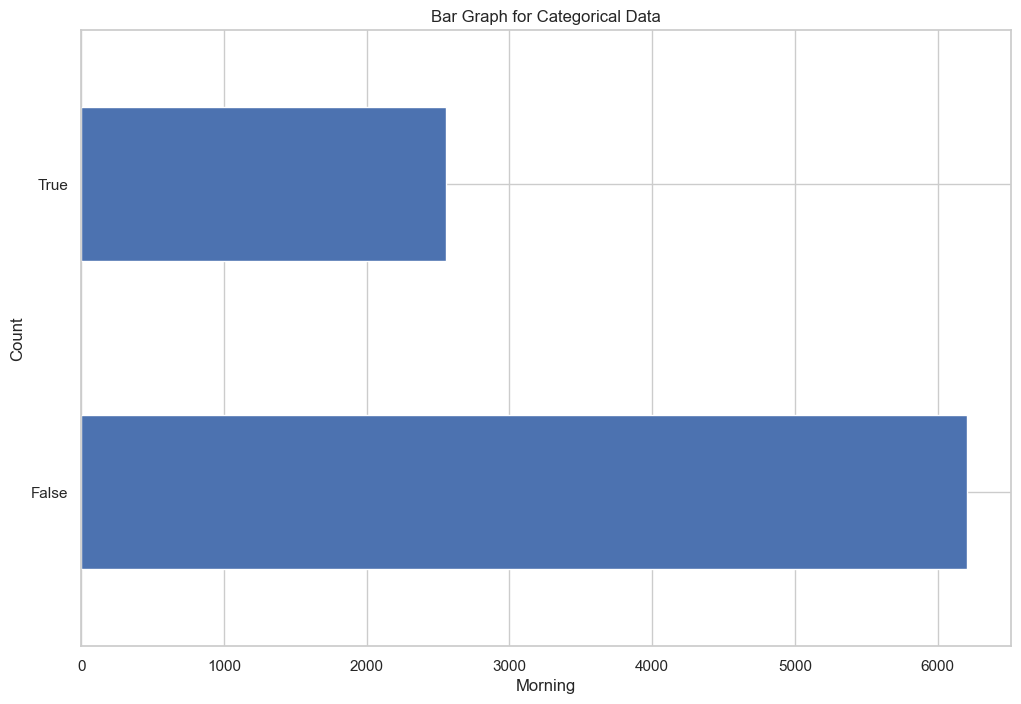

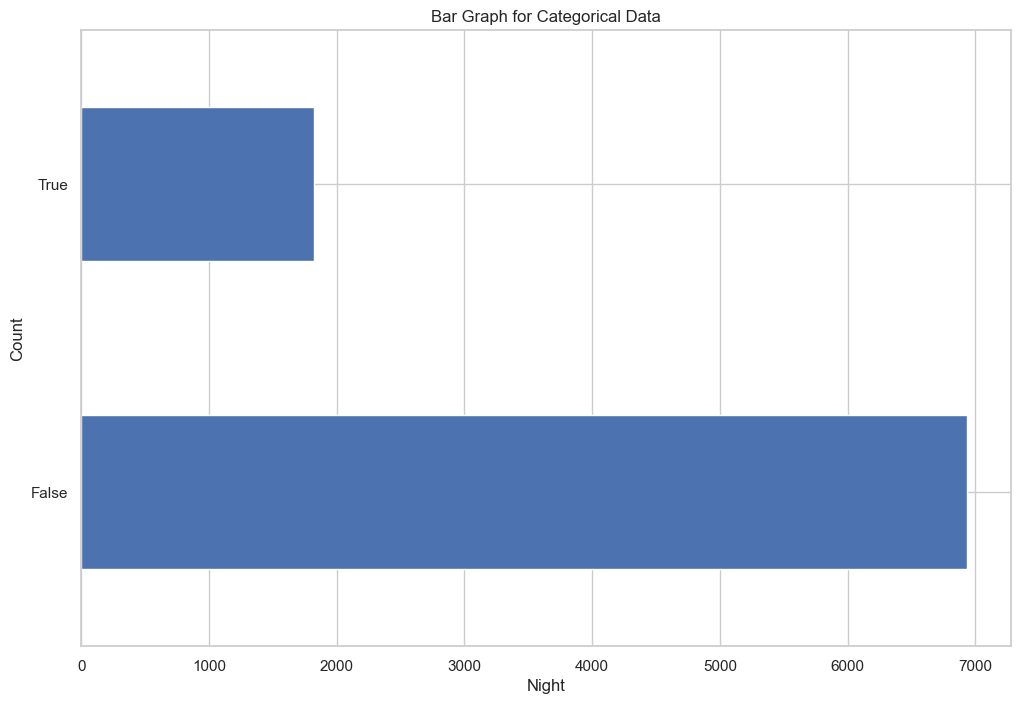

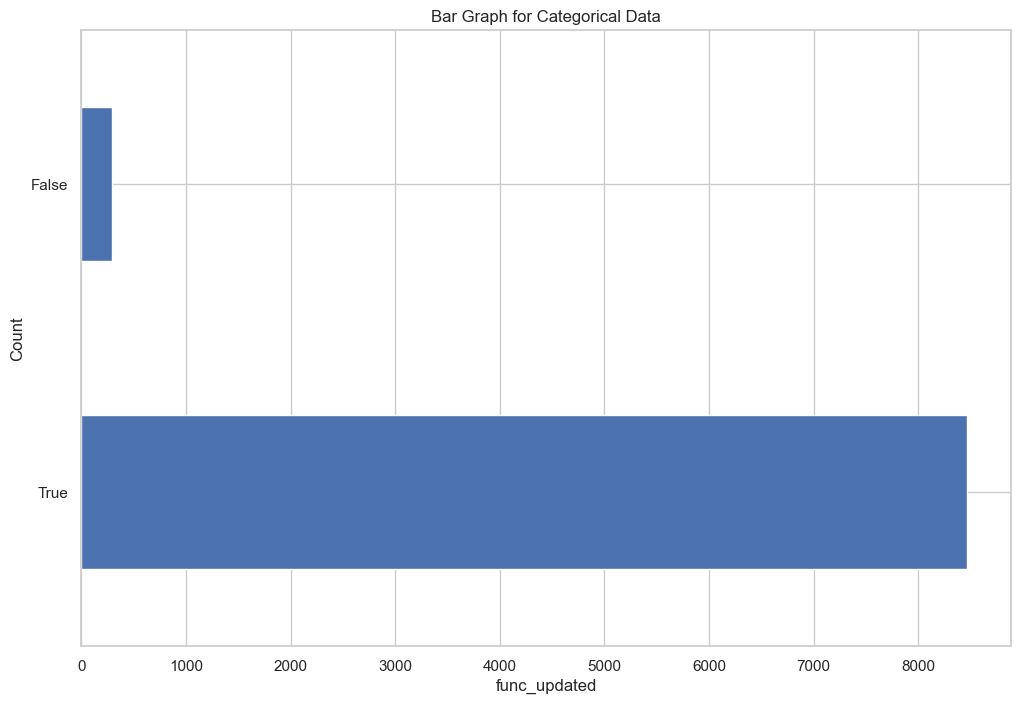

In [35]:
columns_to_plot = ['Holiday_updated', 'Autumn', 'Summer','Spring','Winter','Afternoon','Evening','Morning','Night', 'func_updated']
for column in columns_to_plot:
    counts = df_updated[column].value_counts()
    # plt.bar(counts.index, counts, color='skyblue')
    counts.plot(kind='barh')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title('Bar Graph for Categorical Data')
    plt.rcParams['figure.figsize'] = (12,8)
    plt.show()

**Visualizing to understand if people prefer to bike in morning, afternoon, evening or night.**

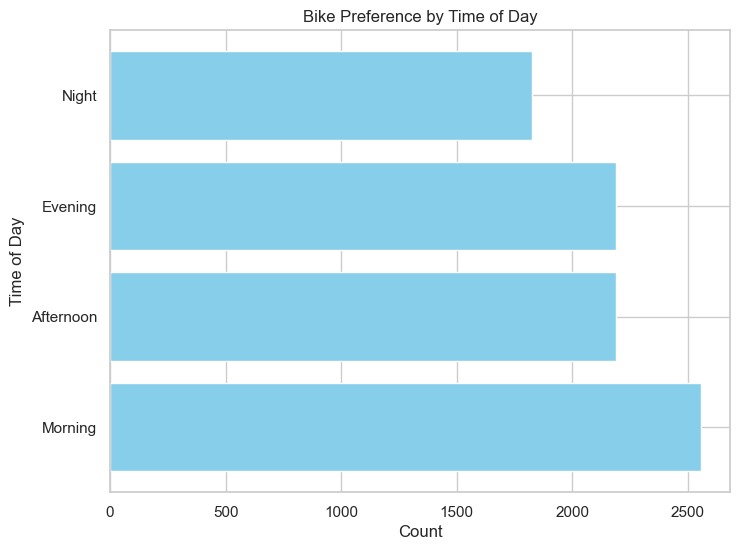

In [36]:
time_categories = ['Morning', 'Afternoon', 'Evening', 'Night']
counts = [df_updated[time].sum() for time in time_categories]

# Create a pie chart to visualize the distribution
plt.figure(figsize=(8, 6))
plt.barh(time_categories, counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Time of Day')
plt.title('Bike Preference by Time of Day')
plt.show()

**Insight from above plot - People prefer morning rides.**

**Visualization to understand if people which season to bike.**

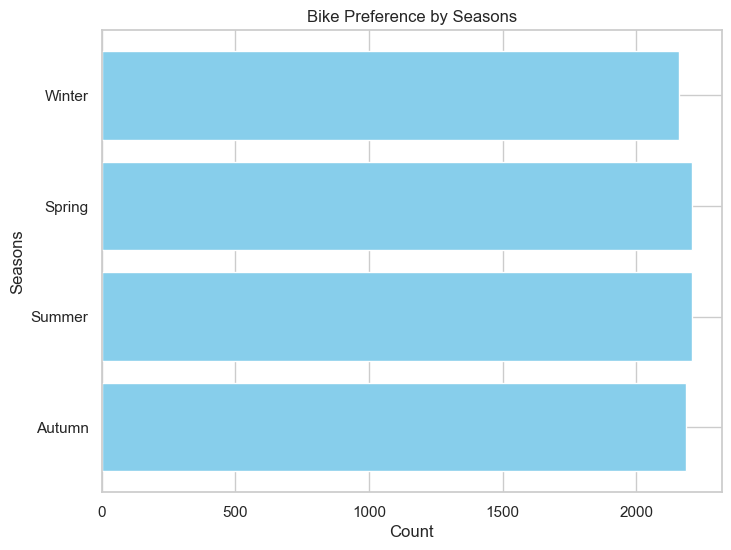

In [37]:
season_categories = ['Autumn', 'Summer', 'Spring', 'Winter']
counts = [df_updated[season].sum() for season in season_categories]

# Create a pie chart to visualize the distribution
plt.figure(figsize=(8, 6))
plt.barh(season_categories, counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Seasons')
plt.title('Bike Preference by Seasons')
plt.show()

**It seems prefer similar across seasons with slightly higher in spring**

# 3.3 - Bivariate Analysis & Hypothesis Testing

In [38]:
df_updated.dtypes

Date                         datetime64[ns]
Rented Bike Count                     int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
quarter                            category
Holiday_updated                        bool
Autumn                                 bool
Spring                                 bool
Summer                                 bool
Winter                                 bool
Afternoon                              bool
Evening                                bool
Morning                                bool
Night                                  bool
func_updated                           bool
dtype: object

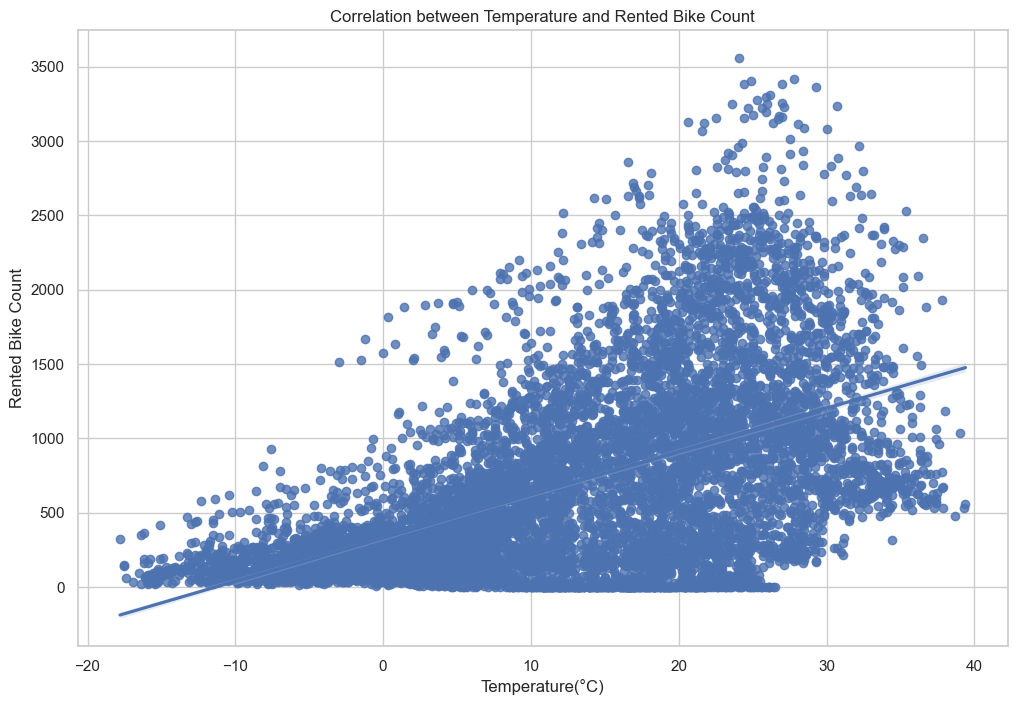

In [39]:
# Scatterplot and add a linear regression model fit 

sns.regplot(x='Temperature(°C)', y='Rented Bike Count', data=df_updated)
plt.title('Correlation between Temperature and Rented Bike Count')
plt.show()

**Insight - Strong positive correlation between Temperature and bike rides**

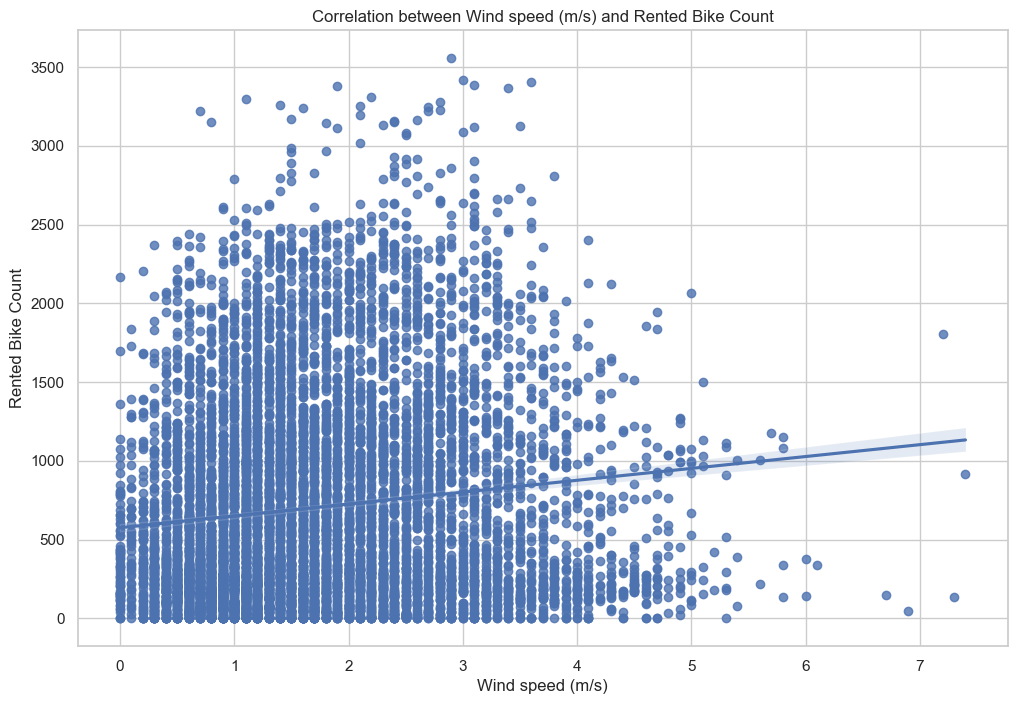

In [40]:
# Scatterplot and add a linear regression model fit 

sns.regplot(x='Wind speed (m/s)', y='Rented Bike Count', data=df_updated)
plt.title('Correlation between Wind speed (m/s) and Rented Bike Count')
plt.show()

**Insight - Not a strong correlation between wind speed and Rented Bike Count**

### Heatmap for relationship identification

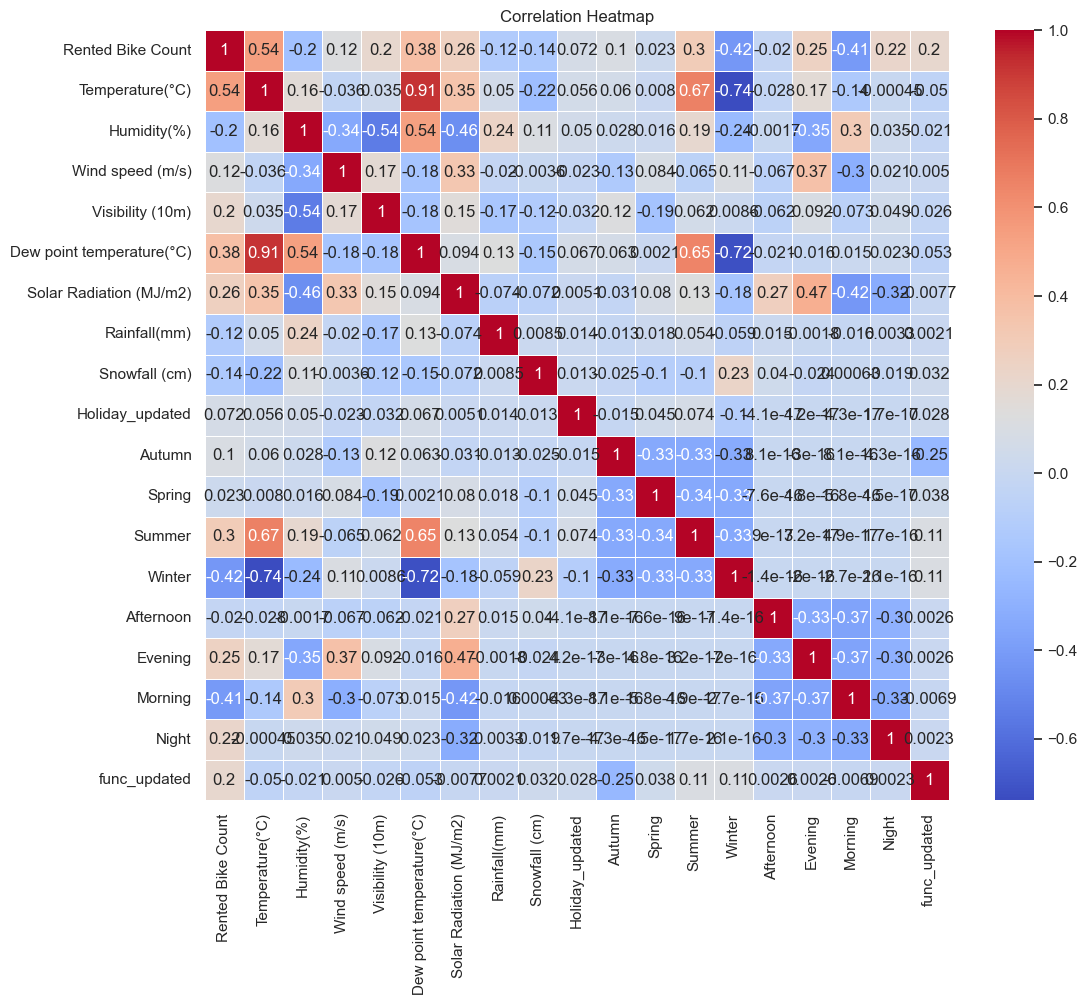

In [41]:
# Create a correlation matrix for the selected columns
correlation_matrix = df_updated[['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
                         'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
                         'Rainfall(mm)', 'Snowfall (cm)', 'Holiday_updated', 'Autumn', 'Spring',
                         'Summer', 'Winter', 'Afternoon', 'Evening', 'Morning', 'Night', 'func_updated']].corr()

# Set the figure size for the heatmap
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set the title
plt.title('Correlation Heatmap')

# Show the heatmap
plt.show()

Correlation heatmap is quite useful to finalise variables for further analysis. 

Winter has a strong negative correlation with rented bike count and temperature has a strong positive correlation.

<font color='blue'>**Hypothesis 1: Solar Radiation & Humidity give 2 measures of weather. We want to check if they are different by independent sample t-test**
</font> 

In [42]:
df_updated.dtypes

Date                         datetime64[ns]
Rented Bike Count                     int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
quarter                            category
Holiday_updated                        bool
Autumn                                 bool
Spring                                 bool
Summer                                 bool
Winter                                 bool
Afternoon                              bool
Evening                                bool
Morning                                bool
Night                                  bool
func_updated                           bool
dtype: object

In [43]:
stats.ttest_rel(df_updated['Solar Radiation (MJ/m2)'], df_updated['Humidity(%)']) 

TtestResult(statistic=-259.7177024262324, pvalue=0.0, df=8759)

**Insight - p-value low, therefore could not reject null hypothesis. mu solar = mu humidity**

<font color='blue'>**Test if Rented bike count is significantly different for the four seasons.**</font> 

Null hypothesis - 𝐻0
:𝜇
=𝜇2=𝜇...=�

In [44]:
from scipy import stats

# Select the data for each season
Autumn = df_updated[df_updated['Autumn']]['Rented Bike Count']
Spring = df_updated[df_updated['Spring']]['Rented Bike Count']
Summer = df_updated[df_updated['Summer']]['Rented Bike Count']
Winter = df_updated[df_updated['Winter']]['Rented Bike Count']

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(Autumn, Spring, Summer, Winter)

# Print the ANOVA results
print('F-statistic: {:.4f}, p-value: {:.4f}'.format(f_statistic, p_value))

F-statistic: 776.4678, p-value: 0.0000


**Insight - Could not reject null hypothesis, there is no significant difference between average Rented bike counts for different seasons.***

# 3.4 - Multiple Linear Regression & Interpreting results

In [45]:
df_updated.dtypes

Date                         datetime64[ns]
Rented Bike Count                     int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
quarter                            category
Holiday_updated                        bool
Autumn                                 bool
Spring                                 bool
Summer                                 bool
Winter                                 bool
Afternoon                              bool
Evening                                bool
Morning                                bool
Night                                  bool
func_updated                           bool
dtype: object

In [46]:
boolean_columns = ['Holiday_updated','Autumn','Spring', 'Summer', 'Winter', 'Afternoon', 'Evening', 'Morning', 'Night', 'func_updated']
# # Convert the specified Boolean columns to integers
for column in boolean_columns:
    df_updated[column] = df_updated[column]*1
# df['Holiday_update'] = df['Holiday_updated'].astype(int)
# df['Autumn'] = df['Autumn'].astype(int)
# df['Spring'] = df['Spring'].astype(int)
# df['Summer'] = df['Summer'].astype(int)
# df['Winter'] = df['Winter'].astype(int)
# df['Afternoon'] = df['Afternoon'].astype(int)
# df['Evening'] = df['Evening'].astype(int)
# df['Morning'] = df['Morning'].astype(int)
# df['Night'] = df['Night'].astype(int)
# df['func_updated'] = df['func_updated'].astype(int)

**Regress Rented Bike Count on Temp, Humidity, Holiday, Rainfall, Evening, Morning, Winter, Solar Radiation, Func_updated**

In [47]:
#doing regression on these columns -- summer led to no change in rsquare. 
X_columns = ['Temperature(°C)','Humidity(%)','Holiday_updated','Rainfall(mm)','Evening','Morning','Winter','Solar Radiation (MJ/m2)','func_updated']
X = df_updated[X_columns]
Y = df_updated['Rented Bike Count']
X = sm.add_constant(X)
est = sm.OLS(Y.astype(float), X.astype(float)).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented Bike Count   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     1245.
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:32:14   Log-Likelihood:                -65489.
No. Observations:                8760   AIC:                         1.310e+05
Df Residuals:                    8750   BIC:                         1.311e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

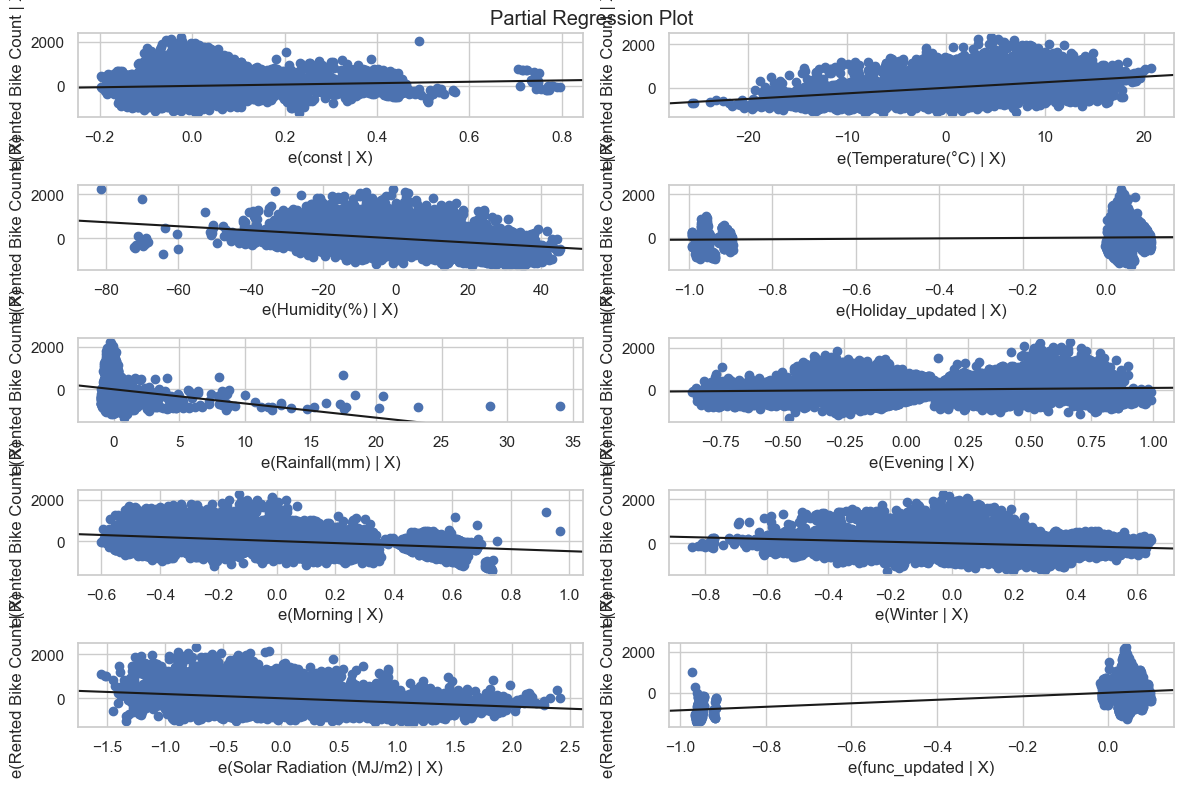

In [48]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(est, fig=fig)
plt.show()

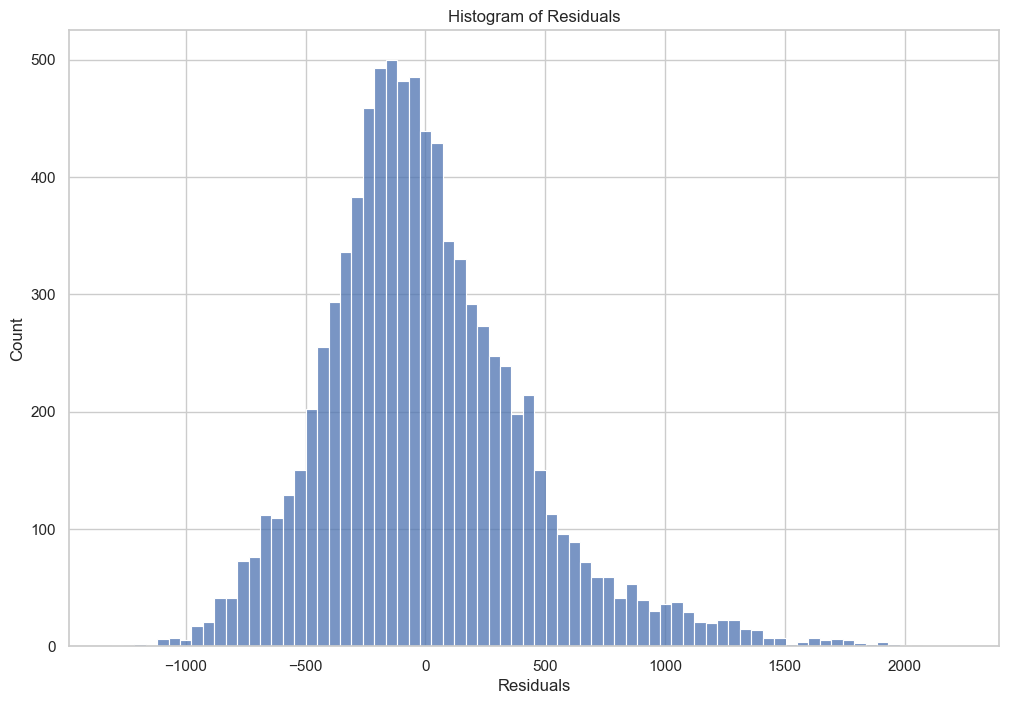

In [49]:
sns.histplot(est.resid)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

In [50]:
# Get the influence analysis results from the fitted model
influence = est.get_influence()
# show the influence analysis summary
# print(influence.summary_table())

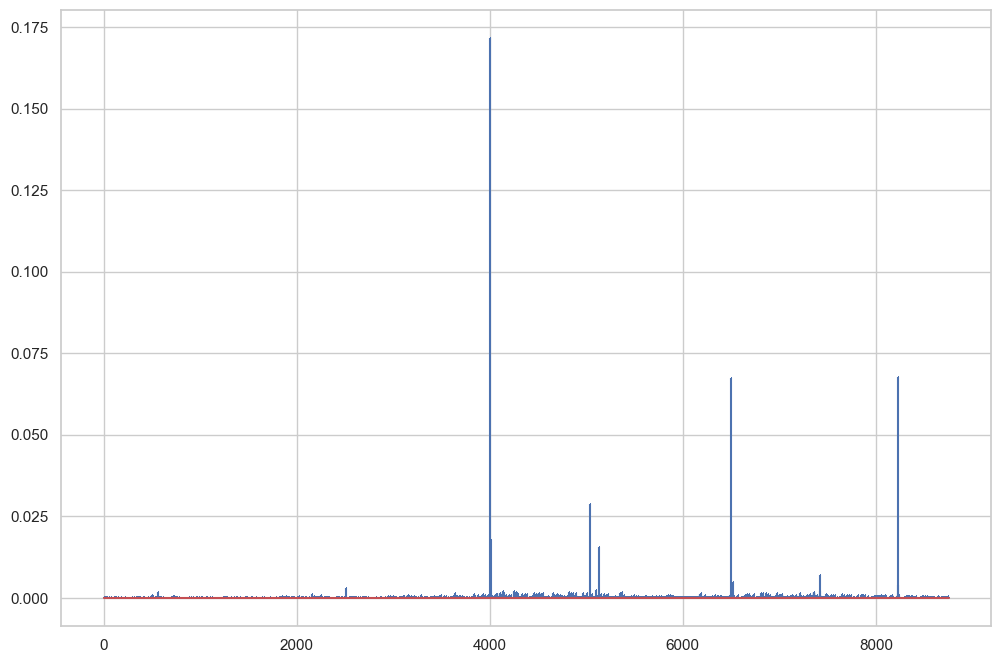

In [51]:
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.show()

In [52]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented Bike Count   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     1245.
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:32:17   Log-Likelihood:                -65489.
No. Observations:                8760   AIC:                         1.310e+05
Df Residuals:                    8750   BIC:                         1.311e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [53]:
import sklearn
from sklearn.decomposition import PCA
pca = PCA()
principal_components = pca.fit_transform(X)
principal_components

array([[ 2.35031119e+01, -1.50237397e+01,  8.13382049e-02, ...,
        -1.21987517e-01,  2.40959105e-02,  0.00000000e+00],
       [ 2.25544302e+01, -1.54579810e+01,  7.11621626e-02, ...,
        -1.20738004e-01,  2.34177393e-02, -0.00000000e+00],
       [ 2.16333644e+01, -1.60901227e+01,  6.16544819e-02, ...,
        -1.18861534e-01,  2.22578186e-02, -0.00000000e+00],
       ...,
       [ 2.04460972e+01, -7.54689974e+00,  7.64783809e-02, ...,
         6.05448896e-03, -8.15310263e-02,  0.00000000e+00],
       [ 1.85349260e+01, -8.31643221e+00,  5.57921155e-02, ...,
         8.24003584e-03, -8.26464942e-02,  0.00000000e+00],
       [ 1.65823312e+01, -8.78911414e+00,  3.41033078e-02, ...,
         9.48514621e-03, -8.30393381e-02,  0.00000000e+00]])

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Calculate VIF
Y = Y.astype(float) 
X = X.astype(float)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

# Inspect VIF Values, round it to 2 decimal places
vif.round(2)

,VIF Factor,features
0,67.49,const
1,2.65,Temperature(°C)
2,1.67,Humidity(%)
3,1.01,Holiday_updated
4,1.07,Rainfall(mm)
5,1.41,Evening
6,1.30,Morning
7,2.37,Winter
8,1.92,Solar Radiation (MJ/m2)
9,1.02,func_updated


1. Overall fit of the model: 56.1% of variance is explained by regression model
2. Regression equation: Rented bike count = 25.5*Temperature(°C) + (-9.2)*Humidity(%) + (100.8054)*Holiday_updated + (-66.66)*Rainfall(mm) + (86.51)*Evening + (-492.25)*Morning + (-329.5382)*Winter + (-191.91)*Solar Radiation (MJ/m2) + (857.72)*func_updated + 309.3319 
3. Significance of individual variables and regression coefficients: All variables have P value less than 0.05 so they are statistically significant.
4. Check if there is any violations of model assumptions: Residuals are normally distributed around zero. The residual vs. predicted value plot shows no autocorrelation. The variance of residuals is also approximately constant.  
5. Check if there is any influential observations: All cook's d scores are less than 1. No outlier
6. Check if there is any multicollinearity issue: VIF values are within - 1 < VIF < 10: moderate correlation, but it is not severe to warrant
corrective measures.

### Vision with respect to how analytics can help provide additional insights
As you describe your analytics vision for Ddareungi, please be specific with respect to:

A. Holiday Impact
1) How do holidays affect bike rentals, and should we adjust bike availability on holidays?
2) Historical rental data and holiday information.
3) Visual analytics of rental patterns on holidays vs. regular days and machine learning to predict holiday-specific demand.

B. Promotion and Marketing
1) Can we identify opportunities for promoting bike rentals during specific hours or under certain weather conditions to increase revenue?
2) Marketing campaigns data, and user feedback.
3) Regression analysis to find associations between rentals and marketing efforts, and A/B testing to measure the impact of promotions.

C. Competitive Benchmarking
1) How does Ddareungi's bike rental service compare with competitors, and how can we gain a competitive advantage?
2) Data on competitors' services and user feedback.
3) Comparative analysis of service quality, pricing, and user satisfaction to identify areas for improvement.data